In [100]:
import pandas as pd 
import datetime as dt
import numpy as np
# import keras
import shap
import plotly.graph_objects as go

from keras.models import Sequential
import tensorflow as tf
from tensorflow import keras
from alphaRNN import *
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.regularizers import l1
from sklearn.metrics import mean_squared_error, r2_score
from plotly.subplots import make_subplots
import statsmodels.api as sm

In [118]:
dataAll = pd.read_csv("dailySummaries.csv")
dataDecTree = pd.read_csv("decisionTreeFeatures.csv")
dataLasso = pd.read_csv("lassoFeatures.csv")
# data = data[data.columns[1:]]
# data = data.loc[:"2022-01-06 00:00:00"]


featData = dataLasso
train_weight = 0.80 # Using 80% of data for training, 20% for testing
split = int(len(featData)*train_weight)
df_train = featData.iloc[:split].copy()
df_test = featData.iloc[split:].copy()
y_train = dataAll["nextDayChangeAave"].iloc[:split].copy()
y_test = dataAll["nextDayChangeAave"].iloc[split:].copy()
price_test = dataAll["aavePrice"].iloc[split:].copy()
dates_test = dataAll["day"].iloc[split:].copy()

In [102]:
X_train = df_train.iloc[:,list(range(1,df_train.shape[1]))]
X_test = df_test.iloc[:,list(range(1,df_train.shape[1]))]

In [103]:
x_train_reg = np.array(X_train)
x_test_reg = np.array(X_test)
y_train_reg = np.array(y_train)
y_test_reg = np.array(y_test)

In [104]:
x_train_reg = np.reshape(x_train_reg, (x_train_reg.shape[0], x_train_reg.shape[1], 1))
x_test_reg = np.reshape(x_test_reg, (x_test_reg.shape[0], x_test_reg.shape[1], 1))

In [105]:
adf, p, usedlag, nobs, cvs,aic=sm.tsa.stattools.adfuller(y_train)

In [106]:
# Null hypothesis: Non Stationarity exists in the series.
# Alternative Hypothesis: Stationarity exists in the series

print("Critical Value: ", adf)
print("p-value" , p)
print("T-values for adfuller: ", cvs)
# Reject the null -- stationarity exists

Critical Value:  -7.202341295055689
p-value 2.347725013495759e-10
T-values for adfuller:  {'1%': -3.4477686860685, '5%': -2.869216670067509, '10%': -2.570859500573892}


In [107]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=df_train.index, y=y_test.values*100,
                    mode='lines',
                    name='Aave Change'),
                    secondary_y=False)
fig.update_layout({
'plot_bgcolor': 'rgba(255, 255, 255, 255)',
'paper_bgcolor': 'rgba(255, 255, 255, 255)',
})
fig.update_xaxes(title="Time (by hour)")
fig.update_yaxes(title="Percent Change (%)")

# Alpha RNN

In [108]:
def AlphaRNN_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(AlphaRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [109]:
max_epoches=1000
batch_size=1000

es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100, min_delta=1e-7, restore_best_weights=True)

In [110]:
model = AlphaRNN_(10,0.0)
model.fit(x_train_reg,y_train_reg,epochs=max_epoches, batch_size=batch_size,callbacks=[es],shuffle=False)

Epoch 1/1000
384/384 [==============================] - 2s 5ms/step - loss: 1.0416
Epoch 2/1000
384/384 [==============================] - 0s 36us/step - loss: 1.0141
Epoch 3/1000
384/384 [==============================] - 0s 122us/step - loss: 0.9830
Epoch 4/1000
384/384 [==============================] - 0s 115us/step - loss: 0.9508
Epoch 5/1000
384/384 [==============================] - 0s 41us/step - loss: 0.9184
Epoch 6/1000
384/384 [==============================] - 0s 55us/step - loss: 0.8847
Epoch 7/1000
384/384 [==============================] - 0s 59us/step - loss: 0.8518
Epoch 8/1000
384/384 [==============================] - 0s 51us/step - loss: 0.8199
Epoch 9/1000
384/384 [==============================] - 0s 38us/step - loss: 0.7889
Epoch 10/1000
384/384 [==============================] - 0s 40us/step - loss: 0.7588
Epoch 11/1000
384/384 [==============================] - 0s 38us/step - loss: 0.7296
Epoch 12/1000
384/384 [==============================] - 0s 40us/step - l

In [111]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
alpha_rnn_3 (AlphaRNN)       (None, 10)                121       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 132
Trainable params: 132
Non-trainable params: 0
_________________________________________________________________


In [112]:
y_pred_train = model.predict(x_train_reg, verbose = 1)
MSE_train= mean_squared_error(y_train,y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print("Train MSE: ", MSE_train)
print("Train r2: ", r2_train)

y_pred = model.predict(x_test_reg, verbose = 1)
MSE_test= mean_squared_error(y_test,y_pred)
r2_test = r2_score(y_test, y_pred, multioutput='variance_weighted')

print("Test MSE: ", MSE_test)
print("Test r2: ", r2_test)

adj_r2 = 1 - (1-r2_test)*(len(y_test_reg)-1)/(len(y_test_reg)-x_test_reg.shape[1]-1)
print("Adjusted r2: ", adj_r2)

384/384 [==============================] - 0s 979us/step
Train MSE:  0.00525344686606016
Train r2:  -0.01502631207393157
97/97 [==============================] - 0s 90us/step
Test MSE:  0.004337881506545527
Test r2:  -0.04856641545163631
Adjusted r2:  -0.2905432805558601


In [113]:
pred_prices = []
for i in range(1,len(df_test)):
    price = price_test.iloc[i-1] * (1 + y_pred[i])
    pred_prices.append(price[0])

In [119]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=dates_test, y=pred_prices,
                    mode='lines',
                    marker=dict(color='red'),
                    name='Aave Predicted'),
                    secondary_y=False)
fig.add_trace(go.Scatter(x=dates_test, y=price_test,
                    mode='lines',
                    marker=dict(color='blue'),
                    name='Aave Actual'),
                    secondary_y=False)
fig.update_layout({
'plot_bgcolor': 'rgba(255, 255, 255, 255)',
'paper_bgcolor': 'rgba(255, 255, 255, 255)',
})
fig.update_xaxes(title="Time (by hour)")
fig.update_yaxes(title="Price (USD)")

In [ ]:
# https://christophm.github.io/interpretable-ml-book/shap.html
# https://github.com/slundberg/shap

In [ ]:
shap.initjs()

In [180]:
def f(X):
    # X - A DataFrame
    predictions = [] 
    for i in range(0,len(X)):
        row =  np.array(X)[i]
        row = np.reshape(row, (1, row.shape[0], 1))
        predictions.append(model.predict(row)[0][0]*100)
    return np.array(predictions)

In [181]:
explainer = shap.KernelExplainer(f, X_train.iloc[:50,:])

In [178]:
# row = np.array(X_test)[2]
# row = np.reshape(row, (1, row.shape[0], 1))
# model.predict(row)[0][0]

0.005578488

/Users/rachellong/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/linear_model/_base.py:138: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 



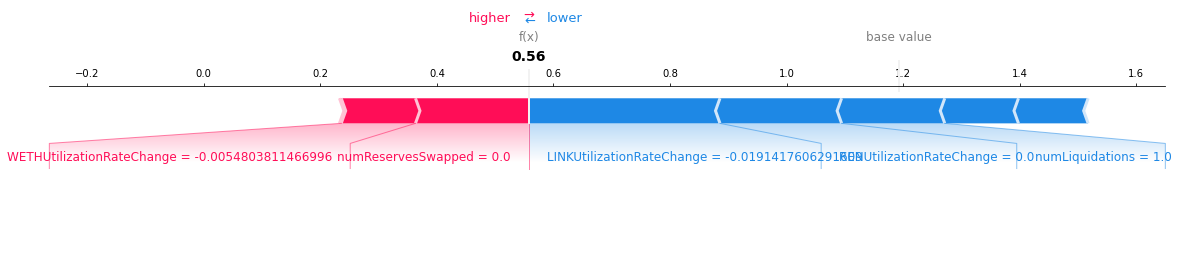

In [182]:
import matplotlib.pyplot as plt
shap_values = explainer.shap_values(X_test.iloc[2,:], nsamples=50)
shap.force_plot(explainer.expected_value, shap_values, X_test.iloc[2,:], show=False, matplotlib=True)
plt.savefig("singleCaseSHAP.png")

  0%|          | 0/50 [00:00<?, ?it/s]

/Users/rachellong/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/linear_model/_base.py:138: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 

/Users/rachellong/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/linear_model/_base.py:138: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipel

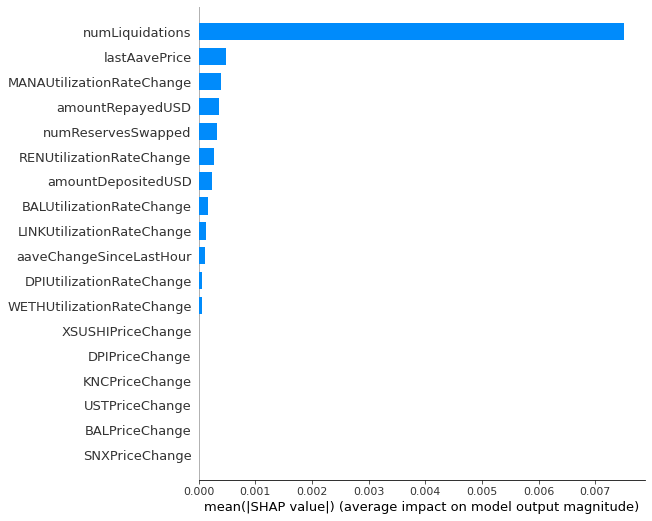

In [93]:

shap_values = explainer.shap_values(X_test.iloc[:50])
shap.summary_plot(shap_values, X_test, plot_type="bar")